<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE2] - First VAE, using a subclass model (MNIST dataset)
<!-- DESC --> Construction and training of a VAE, using model subclass, with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a still more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard

from modules.models    import VAE
from modules.layers    import SamplingLayer
from modules.callbacks import ImagesCallback, BestModelCallback
from modules.datagen   import MNIST

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE2.005'
datasets_dir = pwk.init('VAE2', run_dir)

VAE.about()

**\*\* Overrided parameters : \*\***

run_dir              : ./run/VAE2_done_001


<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.22
Notebook id          : VAE2
Run time             : Monday 22 March 2021, 14:45:03
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run/VAE2_done_001
Update keras cache   : False
Save figs            : True
Path figs            : ./run/VAE2_done_001/figs


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.4.0
Keras version        : 2.4.0


## Step 2 - Parameters
`scale` : With scale=1, we need 1'30s on a GPU V100 ...and >20' on a CPU !\
`latent_dim` : 2 dimensions is small, but usefull to draw !


`loss_weights` : Our **loss function** is the weighted sum of two loss:
 - `r_loss` which measures the loss during reconstruction.  
 - `kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where : `total_loss = k1*r_loss + k2*kl_loss`  
In practice, a value of \[1,6e-4\] gives good results here.


In [2]:
latent_dim    = 2
loss_weights  = [1,6e-4]

scale         = 1
seed          = 123

batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('latent_dim', 'loss_weights', 'scale', 'seed', 'batch_size', 'epochs')

**\*\* Overrided parameters : \*\***

latent_dim           : 2
loss_weights         : [1, 0.001]
scale                : 1
seed                 : 123
batch_size           : 64
epochs               : 10


## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)


Dataset loaded.
Concatenated.
Shuffled.
rescaled (1).
Normalized.
Reshaped.
splited (1).


x_train shape is  :  (70000, 28, 28, 1)
x_test  shape is  :  (0, 28, 28, 1)
y_train shape is  :  (70000,)
y_test  shape is  :  (0,)
Blake2b digest is :  0c903710d4d28b01c174


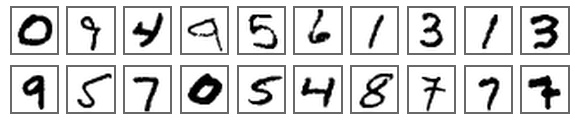

In [4]:
x_data, y_data, _,_ = MNIST.get_data(seed=seed, scale=scale, train_prop=1 )

pwk.plot_images(x_data[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model
In this example, we will use a **custom model**.
For this, we will use :
 - `SamplingLayer`, which generates a vector z from the parameters z_mean and z_log_var - See : [SamplingLayer.py](./modules/layers/SamplingLayer.py)
 - `VAE`, a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.compile()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
decoder.compile()

#### VAE
`VAE` is a custom model with a specific train_step - See : [VAE.py](./modules/models/VAE.py)

In [7]:
vae = VAE(encoder, decoder, loss_weights)

vae.compile(optimizer='adam')

Fidle VAE is ready :-)  loss_weights=[1, 0.001]


## Step 5 - Train
### 5.1 - Using two nice custom callbacks :-)
Two custom callbacks are used:
 - `ImagesCallback` : qui va sauvegarder des images durant l'apprentissage - See [ImagesCallback.py](./modules/callbacks/ImagesCallback.py)
 - `BestModelCallback` : qui sauvegardera le meilleur model - See [BestModelCallback.py](./modules/callbacks/BestModelCallback.py)

In [8]:
callback_images      = ImagesCallback(x=x_data, z_dim=latent_dim, nb_images=5, from_z=True, from_random=True, run_dir=run_dir)
callback_bestmodel   = BestModelCallback( run_dir + '/models/best_model.h5' )
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

callbacks_list = [callback_images, callback_bestmodel]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [9]:
pwk.chrono_start()

history = vae.fit(x_data, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

Epoch 1/10


   1/1094 [..............................] - ETA: 1:08:55 - loss: 0.6929 - r_loss: 0.6929 - kl_loss: 1.9311e-07

  12/1094 [..............................] - ETA: 5s - loss: 0.6369 - r_loss: 0.6321 - kl_loss: 0.0048         

  23/1094 [..............................] - ETA: 5s - loss: 0.5544 - r_loss: 0.5512 - kl_loss: 0.0031

  35/1094 [..............................] - ETA: 4s - loss: 0.4853 - r_loss: 0.4830 - kl_loss: 0.0023

  47/1094 [>.............................] - ETA: 4s - loss: 0.4341 - r_loss: 0.4316 - kl_loss: 0.0025

  59/1094 [>.............................] - ETA: 4s - loss: 0.4011 - r_loss: 0.3984 - kl_loss: 0.0027

  71/1094 [>.............................] - ETA: 4s - loss: 0.3792 - r_loss: 0.3766 - kl_loss: 0.0026

  83/1094 [=>............................] - ETA: 4s - loss: 0.3629 - r_loss: 0.3601 - kl_loss: 0.0028

  95/1094 [=>............................] - ETA: 4s - loss: 0.3504 - r_loss: 0.3476 - kl_loss: 0.0028

 107/1094 [=>............................] - ETA: 4s - loss: 0.3406 - r_loss: 0.3377 - kl_loss: 0.0029

 119/1094 [==>...........................] - ETA: 4s - loss: 0.3327 - r_loss: 0.3297 - kl_loss: 0.0030

 131/1094 [==>...........................] - ETA: 4s - loss: 0.3260 - r_loss: 0.3230 - kl_loss: 0.0030

 143/1094 [==>...........................] - ETA: 4s - loss: 0.3202 - r_loss: 0.3172 - kl_loss: 0.0031

 155/1094 [===>..........................] - ETA: 4s - loss: 0.3149 - r_loss: 0.3118 - kl_loss: 0.0031

 167/1094 [===>..........................] - ETA: 4s - loss: 0.3104 - r_loss: 0.3072 - kl_loss: 0.0031

 179/1094 [===>..........................] - ETA: 4s - loss: 0.3063 - r_loss: 0.3032 - kl_loss: 0.0031

 190/1094 [====>.........................] - ETA: 4s - loss: 0.3033 - r_loss: 0.3001 - kl_loss: 0.0031

 202/1094 [====>.........................] - ETA: 4s - loss: 0.3003 - r_loss: 0.2971 - kl_loss: 0.0032

 214/1094 [====>.........................] - ETA: 3s - loss: 0.2973 - r_loss: 0.2941 - kl_loss: 0.0032

 226/1094 [=====>........................] - ETA: 3s - loss: 0.2944 - r_loss: 0.2913 - kl_loss: 0.0032

 238/1094 [=====>........................] - ETA: 3s - loss: 0.2918 - r_loss: 0.2886 - kl_loss: 0.0032

 250/1094 [=====>........................] - ETA: 3s - loss: 0.2892 - r_loss: 0.2859 - kl_loss: 0.0032

 262/1094 [======>.......................] - ETA: 3s - loss: 0.2867 - r_loss: 0.2834 - kl_loss: 0.0033

 274/1094 [======>.......................] - ETA: 3s - loss: 0.2844 - r_loss: 0.2810 - kl_loss: 0.0033

 286/1094 [======>.......................] - ETA: 3s - loss: 0.2821 - r_loss: 0.2787 - kl_loss: 0.0034

 298/1094 [=======>......................] - ETA: 3s - loss: 0.2799 - r_loss: 0.2765 - kl_loss: 0.0034

 310/1094 [=======>......................] - ETA: 3s - loss: 0.2779 - r_loss: 0.2745 - kl_loss: 0.0034

 322/1094 [=======>......................] - ETA: 3s - loss: 0.2761 - r_loss: 0.2727 - kl_loss: 0.0035

 334/1094 [========>.....................] - ETA: 3s - loss: 0.2744 - r_loss: 0.2709 - kl_loss: 0.0035

 346/1094 [========>.....................] - ETA: 3s - loss: 0.2728 - r_loss: 0.2693 - kl_loss: 0.0035

 358/1094 [========>.....................] - ETA: 3s - loss: 0.2711 - r_loss: 0.2676 - kl_loss: 0.0035

 370/1094 [=========>....................] - ETA: 3s - loss: 0.2696 - r_loss: 0.2660 - kl_loss: 0.0036

 382/1094 [=========>....................] - ETA: 3s - loss: 0.2681 - r_loss: 0.2645 - kl_loss: 0.0036

 394/1094 [=========>....................] - ETA: 3s - loss: 0.2667 - r_loss: 0.2631 - kl_loss: 0.0036

 406/1094 [==========>...................] - ETA: 3s - loss: 0.2653 - r_loss: 0.2617 - kl_loss: 0.0036

 418/1094 [==========>...................] - ETA: 3s - loss: 0.2641 - r_loss: 0.2605 - kl_loss: 0.0036

 430/1094 [==========>...................] - ETA: 2s - loss: 0.2628 - r_loss: 0.2592 - kl_loss: 0.0036

 442/1094 [===========>..................] - ETA: 2s - loss: 0.2617 - r_loss: 0.2581 - kl_loss: 0.0037

 454/1094 [===========>..................] - ETA: 2s - loss: 0.2606 - r_loss: 0.2570 - kl_loss: 0.0037

 466/1094 [===========>..................] - ETA: 2s - loss: 0.2595 - r_loss: 0.2559 - kl_loss: 0.0037

 478/1094 [============>.................] - ETA: 2s - loss: 0.2585 - r_loss: 0.2548 - kl_loss: 0.0037

 490/1094 [============>.................] - ETA: 2s - loss: 0.2576 - r_loss: 0.2539 - kl_loss: 0.0037

 502/1094 [============>.................] - ETA: 2s - loss: 0.2567 - r_loss: 0.2530 - kl_loss: 0.0037

 514/1094 [=============>................] - ETA: 2s - loss: 0.2558 - r_loss: 0.2521 - kl_loss: 0.0037

 526/1094 [=============>................] - ETA: 2s - loss: 0.2549 - r_loss: 0.2512 - kl_loss: 0.0037

 538/1094 [=============>................] - ETA: 2s - loss: 0.2541 - r_loss: 0.2503 - kl_loss: 0.0037

 550/1094 [==============>...............] - ETA: 2s - loss: 0.2533 - r_loss: 0.2496 - kl_loss: 0.0037

 562/1094 [==============>...............] - ETA: 2s - loss: 0.2525 - r_loss: 0.2487 - kl_loss: 0.0037

 574/1094 [==============>...............] - ETA: 2s - loss: 0.2517 - r_loss: 0.2479 - kl_loss: 0.0037

 586/1094 [===============>..............] - ETA: 2s - loss: 0.2509 - r_loss: 0.2472 - kl_loss: 0.0037

 598/1094 [===============>..............] - ETA: 2s - loss: 0.2502 - r_loss: 0.2465 - kl_loss: 0.0037

 610/1094 [===============>..............] - ETA: 2s - loss: 0.2494 - r_loss: 0.2457 - kl_loss: 0.0037

 622/1094 [================>.............] - ETA: 2s - loss: 0.2488 - r_loss: 0.2451 - kl_loss: 0.0038

 634/1094 [================>.............] - ETA: 2s - loss: 0.2482 - r_loss: 0.2444 - kl_loss: 0.0038

 646/1094 [================>.............] - ETA: 2s - loss: 0.2476 - r_loss: 0.2438 - kl_loss: 0.0038

 658/1094 [=================>............] - ETA: 1s - loss: 0.2470 - r_loss: 0.2432 - kl_loss: 0.0038

 670/1094 [=================>............] - ETA: 1s - loss: 0.2463 - r_loss: 0.2426 - kl_loss: 0.0038

 682/1094 [=================>............] - ETA: 1s - loss: 0.2458 - r_loss: 0.2420 - kl_loss: 0.0038

 694/1094 [==================>...........] - ETA: 1s - loss: 0.2452 - r_loss: 0.2414 - kl_loss: 0.0038

 706/1094 [==================>...........] - ETA: 1s - loss: 0.2446 - r_loss: 0.2408 - kl_loss: 0.0038

 718/1094 [==================>...........] - ETA: 1s - loss: 0.2441 - r_loss: 0.2403 - kl_loss: 0.0038

 730/1094 [===================>..........] - ETA: 1s - loss: 0.2435 - r_loss: 0.2397 - kl_loss: 0.0038

 742/1094 [===================>..........] - ETA: 1s - loss: 0.2430 - r_loss: 0.2392 - kl_loss: 0.0038

 754/1094 [===================>..........] - ETA: 1s - loss: 0.2425 - r_loss: 0.2387 - kl_loss: 0.0038

 766/1094 [====================>.........] - ETA: 1s - loss: 0.2420 - r_loss: 0.2382 - kl_loss: 0.0038

 778/1094 [====================>.........] - ETA: 1s - loss: 0.2415 - r_loss: 0.2377 - kl_loss: 0.0038

 790/1094 [====================>.........] - ETA: 1s - loss: 0.2410 - r_loss: 0.2372 - kl_loss: 0.0038

 802/1094 [====================>.........] - ETA: 1s - loss: 0.2406 - r_loss: 0.2368 - kl_loss: 0.0038

 814/1094 [=====================>........] - ETA: 1s - loss: 0.2401 - r_loss: 0.2363 - kl_loss: 0.0038

 826/1094 [=====================>........] - ETA: 1s - loss: 0.2396 - r_loss: 0.2358 - kl_loss: 0.0038

 838/1094 [=====================>........] - ETA: 1s - loss: 0.2391 - r_loss: 0.2353 - kl_loss: 0.0038

 850/1094 [======================>.......] - ETA: 1s - loss: 0.2386 - r_loss: 0.2348 - kl_loss: 0.0038

 862/1094 [======================>.......] - ETA: 1s - loss: 0.2382 - r_loss: 0.2344 - kl_loss: 0.0038

 874/1094 [======================>.......] - ETA: 0s - loss: 0.2378 - r_loss: 0.2340 - kl_loss: 0.0038

 886/1094 [=======================>......] - ETA: 0s - loss: 0.2374 - r_loss: 0.2336 - kl_loss: 0.0038

 898/1094 [=======================>......] - ETA: 0s - loss: 0.2370 - r_loss: 0.2332 - kl_loss: 0.0038

 910/1094 [=======================>......] - ETA: 0s - loss: 0.2366 - r_loss: 0.2328 - kl_loss: 0.0038

 922/1094 [========================>.....] - ETA: 0s - loss: 0.2363 - r_loss: 0.2324 - kl_loss: 0.0038

 934/1094 [========================>.....] - ETA: 0s - loss: 0.2359 - r_loss: 0.2320 - kl_loss: 0.0038

 946/1094 [========================>.....] - ETA: 0s - loss: 0.2355 - r_loss: 0.2317 - kl_loss: 0.0038

 958/1094 [=========================>....] - ETA: 0s - loss: 0.2351 - r_loss: 0.2313 - kl_loss: 0.0038

 970/1094 [=========================>....] - ETA: 0s - loss: 0.2347 - r_loss: 0.2309 - kl_loss: 0.0038

 982/1094 [=========================>....] - ETA: 0s - loss: 0.2343 - r_loss: 0.2305 - kl_loss: 0.0038

 994/1094 [==========================>...] - ETA: 0s - loss: 0.2340 - r_loss: 0.2301 - kl_loss: 0.0038

1006/1094 [==========================>...] - ETA: 0s - loss: 0.2336 - r_loss: 0.2298 - kl_loss: 0.0038

1018/1094 [==========================>...] - ETA: 0s - loss: 0.2333 - r_loss: 0.2294 - kl_loss: 0.0038

1030/1094 [===========================>..] - ETA: 0s - loss: 0.2329 - r_loss: 0.2291 - kl_loss: 0.0038

1042/1094 [===========================>..] - ETA: 0s - loss: 0.2326 - r_loss: 0.2288 - kl_loss: 0.0038

1054/1094 [===========================>..] - ETA: 0s - loss: 0.2323 - r_loss: 0.2284 - kl_loss: 0.0038

1066/1094 [============================>.] - ETA: 0s - loss: 0.2319 - r_loss: 0.2281 - kl_loss: 0.0038

1078/1094 [============================>.] - ETA: 0s - loss: 0.2316 - r_loss: 0.2278 - kl_loss: 0.0038

1090/1094 [============================>.] - ETA: 0s - loss: 0.2314 - r_loss: 0.2275 - kl_loss: 0.0038

1094/1094 [==============================] - ETA: 0s - loss: 0.2313 - r_loss: 0.2274 - kl_loss: 0.0038

1094/1094 [==============================] - 9s 5ms/step - loss: 0.2313 - r_loss: 0.2274 - kl_loss: 0.0038


Epoch 2/10
   1/1094 [..............................] - ETA: 5s - loss: 0.2039 - r_loss: 0.2003 - kl_loss: 0.0036

  13/1094 [..............................] - ETA: 4s - loss: 0.2021 - r_loss: 0.1980 - kl_loss: 0.0041

  25/1094 [..............................] - ETA: 4s - loss: 0.2029 - r_loss: 0.1988 - kl_loss: 0.0041

  37/1094 [>.............................] - ETA: 4s - loss: 0.2035 - r_loss: 0.1994 - kl_loss: 0.0040

  49/1094 [>.............................] - ETA: 4s - loss: 0.2042 - r_loss: 0.2002 - kl_loss: 0.0040

  61/1094 [>.............................] - ETA: 4s - loss: 0.2035 - r_loss: 0.1995 - kl_loss: 0.0040

  73/1094 [=>............................] - ETA: 4s - loss: 0.2027 - r_loss: 0.1987 - kl_loss: 0.0040

  85/1094 [=>............................] - ETA: 4s - loss: 0.2029 - r_loss: 0.1989 - kl_loss: 0.0040

  97/1094 [=>............................] - ETA: 4s - loss: 0.2030 - r_loss: 0.1990 - kl_loss: 0.0040

 109/1094 [=>............................] - ETA: 4s - loss: 0.2027 - r_loss: 0.1986 - kl_loss: 0.0041

 121/1094 [==>...........................] - ETA: 4s - loss: 0.2024 - r_loss: 0.1983 - kl_loss: 0.0041

 133/1094 [==>...........................] - ETA: 4s - loss: 0.2022 - r_loss: 0.1982 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.2022 - r_loss: 0.1981 - kl_loss: 0.0041

 156/1094 [===>..........................] - ETA: 4s - loss: 0.2021 - r_loss: 0.1980 - kl_loss: 0.0041

 168/1094 [===>..........................] - ETA: 4s - loss: 0.2020 - r_loss: 0.1980 - kl_loss: 0.0041

 180/1094 [===>..........................] - ETA: 4s - loss: 0.2019 - r_loss: 0.1978 - kl_loss: 0.0041

 192/1094 [====>.........................] - ETA: 4s - loss: 0.2017 - r_loss: 0.1976 - kl_loss: 0.0041

 204/1094 [====>.........................] - ETA: 3s - loss: 0.2018 - r_loss: 0.1978 - kl_loss: 0.0041

 216/1094 [====>.........................] - ETA: 3s - loss: 0.2017 - r_loss: 0.1976 - kl_loss: 0.0041

 228/1094 [=====>........................] - ETA: 3s - loss: 0.2015 - r_loss: 0.1974 - kl_loss: 0.0041

 240/1094 [=====>........................] - ETA: 3s - loss: 0.2014 - r_loss: 0.1973 - kl_loss: 0.0041

 252/1094 [=====>........................] - ETA: 3s - loss: 0.2014 - r_loss: 0.1973 - kl_loss: 0.0041

 264/1094 [======>.......................] - ETA: 3s - loss: 0.2011 - r_loss: 0.1970 - kl_loss: 0.0041

 276/1094 [======>.......................] - ETA: 3s - loss: 0.2009 - r_loss: 0.1968 - kl_loss: 0.0041

 288/1094 [======>.......................] - ETA: 3s - loss: 0.2009 - r_loss: 0.1969 - kl_loss: 0.0041

 300/1094 [=======>......................] - ETA: 3s - loss: 0.2009 - r_loss: 0.1969 - kl_loss: 0.0041

 312/1094 [=======>......................] - ETA: 3s - loss: 0.2008 - r_loss: 0.1967 - kl_loss: 0.0041

 324/1094 [=======>......................] - ETA: 3s - loss: 0.2008 - r_loss: 0.1967 - kl_loss: 0.0041

 336/1094 [========>.....................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1965 - kl_loss: 0.0041

 348/1094 [========>.....................] - ETA: 3s - loss: 0.2006 - r_loss: 0.1965 - kl_loss: 0.0041

 360/1094 [========>.....................] - ETA: 3s - loss: 0.2004 - r_loss: 0.1963 - kl_loss: 0.0041

 372/1094 [=========>....................] - ETA: 3s - loss: 0.2002 - r_loss: 0.1961 - kl_loss: 0.0041

 384/1094 [=========>....................] - ETA: 3s - loss: 0.2002 - r_loss: 0.1961 - kl_loss: 0.0041

 396/1094 [=========>....................] - ETA: 3s - loss: 0.2001 - r_loss: 0.1960 - kl_loss: 0.0041

 408/1094 [==========>...................] - ETA: 3s - loss: 0.2000 - r_loss: 0.1959 - kl_loss: 0.0041

 420/1094 [==========>...................] - ETA: 3s - loss: 0.1999 - r_loss: 0.1958 - kl_loss: 0.0041

 432/1094 [==========>...................] - ETA: 2s - loss: 0.1998 - r_loss: 0.1957 - kl_loss: 0.0041

 444/1094 [===========>..................] - ETA: 2s - loss: 0.1998 - r_loss: 0.1957 - kl_loss: 0.0041

 456/1094 [===========>..................] - ETA: 2s - loss: 0.1998 - r_loss: 0.1957 - kl_loss: 0.0041

 468/1094 [===========>..................] - ETA: 2s - loss: 0.1996 - r_loss: 0.1955 - kl_loss: 0.0041

 480/1094 [============>.................] - ETA: 2s - loss: 0.1995 - r_loss: 0.1954 - kl_loss: 0.0041

 492/1094 [============>.................] - ETA: 2s - loss: 0.1995 - r_loss: 0.1954 - kl_loss: 0.0041

 504/1094 [============>.................] - ETA: 2s - loss: 0.1995 - r_loss: 0.1954 - kl_loss: 0.0041

 516/1094 [=============>................] - ETA: 2s - loss: 0.1993 - r_loss: 0.1953 - kl_loss: 0.0041

 528/1094 [=============>................] - ETA: 2s - loss: 0.1992 - r_loss: 0.1951 - kl_loss: 0.0041

 540/1094 [=============>................] - ETA: 2s - loss: 0.1991 - r_loss: 0.1950 - kl_loss: 0.0041

 552/1094 [==============>...............] - ETA: 2s - loss: 0.1990 - r_loss: 0.1949 - kl_loss: 0.0041

 564/1094 [==============>...............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1948 - kl_loss: 0.0041

 576/1094 [==============>...............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1947 - kl_loss: 0.0041

 588/1094 [===============>..............] - ETA: 2s - loss: 0.1988 - r_loss: 0.1947 - kl_loss: 0.0041

 600/1094 [===============>..............] - ETA: 2s - loss: 0.1987 - r_loss: 0.1946 - kl_loss: 0.0041

 612/1094 [===============>..............] - ETA: 2s - loss: 0.1987 - r_loss: 0.1946 - kl_loss: 0.0041

 624/1094 [================>.............] - ETA: 2s - loss: 0.1986 - r_loss: 0.1945 - kl_loss: 0.0041

 636/1094 [================>.............] - ETA: 2s - loss: 0.1986 - r_loss: 0.1945 - kl_loss: 0.0041

 648/1094 [================>.............] - ETA: 1s - loss: 0.1986 - r_loss: 0.1945 - kl_loss: 0.0041

 660/1094 [=================>............] - ETA: 1s - loss: 0.1984 - r_loss: 0.1944 - kl_loss: 0.0041

 672/1094 [=================>............] - ETA: 1s - loss: 0.1984 - r_loss: 0.1943 - kl_loss: 0.0041

 684/1094 [=================>............] - ETA: 1s - loss: 0.1984 - r_loss: 0.1943 - kl_loss: 0.0041

 696/1094 [==================>...........] - ETA: 1s - loss: 0.1983 - r_loss: 0.1942 - kl_loss: 0.0041

 707/1094 [==================>...........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1941 - kl_loss: 0.0041

 718/1094 [==================>...........] - ETA: 1s - loss: 0.1982 - r_loss: 0.1941 - kl_loss: 0.0041

 729/1094 [==================>...........] - ETA: 1s - loss: 0.1981 - r_loss: 0.1940 - kl_loss: 0.0041

 740/1094 [===================>..........] - ETA: 1s - loss: 0.1980 - r_loss: 0.1939 - kl_loss: 0.0041

 751/1094 [===================>..........] - ETA: 1s - loss: 0.1981 - r_loss: 0.1940 - kl_loss: 0.0041

 762/1094 [===================>..........] - ETA: 1s - loss: 0.1980 - r_loss: 0.1939 - kl_loss: 0.0041

 773/1094 [====================>.........] - ETA: 1s - loss: 0.1979 - r_loss: 0.1938 - kl_loss: 0.0041

 784/1094 [====================>.........] - ETA: 1s - loss: 0.1979 - r_loss: 0.1938 - kl_loss: 0.0041

 795/1094 [====================>.........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1937 - kl_loss: 0.0041

 806/1094 [=====================>........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1937 - kl_loss: 0.0041

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1937 - kl_loss: 0.0041

 828/1094 [=====================>........] - ETA: 1s - loss: 0.1978 - r_loss: 0.1937 - kl_loss: 0.0041

 839/1094 [======================>.......] - ETA: 1s - loss: 0.1977 - r_loss: 0.1936 - kl_loss: 0.0041

 850/1094 [======================>.......] - ETA: 1s - loss: 0.1977 - r_loss: 0.1936 - kl_loss: 0.0041

 861/1094 [======================>.......] - ETA: 1s - loss: 0.1976 - r_loss: 0.1935 - kl_loss: 0.0041

 872/1094 [======================>.......] - ETA: 0s - loss: 0.1975 - r_loss: 0.1935 - kl_loss: 0.0041

 884/1094 [=======================>......] - ETA: 0s - loss: 0.1974 - r_loss: 0.1934 - kl_loss: 0.0041

 895/1094 [=======================>......] - ETA: 0s - loss: 0.1974 - r_loss: 0.1933 - kl_loss: 0.0041

 906/1094 [=======================>......] - ETA: 0s - loss: 0.1974 - r_loss: 0.1933 - kl_loss: 0.0041

 917/1094 [========================>.....] - ETA: 0s - loss: 0.1974 - r_loss: 0.1933 - kl_loss: 0.0041

 928/1094 [========================>.....] - ETA: 0s - loss: 0.1973 - r_loss: 0.1932 - kl_loss: 0.0041

 939/1094 [========================>.....] - ETA: 0s - loss: 0.1973 - r_loss: 0.1932 - kl_loss: 0.0041

 950/1094 [=========================>....] - ETA: 0s - loss: 0.1973 - r_loss: 0.1932 - kl_loss: 0.0041

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1972 - r_loss: 0.1931 - kl_loss: 0.0041

 972/1094 [=========================>....] - ETA: 0s - loss: 0.1972 - r_loss: 0.1931 - kl_loss: 0.0041

 983/1094 [=========================>....] - ETA: 0s - loss: 0.1972 - r_loss: 0.1931 - kl_loss: 0.0041

 994/1094 [==========================>...] - ETA: 0s - loss: 0.1971 - r_loss: 0.1930 - kl_loss: 0.0041

1005/1094 [==========================>...] - ETA: 0s - loss: 0.1970 - r_loss: 0.1929 - kl_loss: 0.0041

1016/1094 [==========================>...] - ETA: 0s - loss: 0.1970 - r_loss: 0.1929 - kl_loss: 0.0041

1027/1094 [===========================>..] - ETA: 0s - loss: 0.1970 - r_loss: 0.1929 - kl_loss: 0.0041

1038/1094 [===========================>..] - ETA: 0s - loss: 0.1970 - r_loss: 0.1929 - kl_loss: 0.0041

1049/1094 [===========================>..] - ETA: 0s - loss: 0.1969 - r_loss: 0.1929 - kl_loss: 0.0041

1060/1094 [============================>.] - ETA: 0s - loss: 0.1969 - r_loss: 0.1928 - kl_loss: 0.0041

1071/1094 [============================>.] - ETA: 0s - loss: 0.1969 - r_loss: 0.1928 - kl_loss: 0.0041

1082/1094 [============================>.] - ETA: 0s - loss: 0.1968 - r_loss: 0.1928 - kl_loss: 0.0041

1093/1094 [============================>.] - ETA: 0s - loss: 0.1968 - r_loss: 0.1927 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1968 - r_loss: 0.1927 - kl_loss: 0.0041


Epoch 3/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1950 - r_loss: 0.1909 - kl_loss: 0.0041

  12/1094 [..............................] - ETA: 5s - loss: 0.1875 - r_loss: 0.1834 - kl_loss: 0.0042

  23/1094 [..............................] - ETA: 4s - loss: 0.1920 - r_loss: 0.1878 - kl_loss: 0.0042

  34/1094 [..............................] - ETA: 4s - loss: 0.1940 - r_loss: 0.1898 - kl_loss: 0.0041

  45/1094 [>.............................] - ETA: 4s - loss: 0.1928 - r_loss: 0.1886 - kl_loss: 0.0042

  56/1094 [>.............................] - ETA: 4s - loss: 0.1927 - r_loss: 0.1885 - kl_loss: 0.0041

  67/1094 [>.............................] - ETA: 4s - loss: 0.1922 - r_loss: 0.1881 - kl_loss: 0.0041

  78/1094 [=>............................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1877 - kl_loss: 0.0041

  89/1094 [=>............................] - ETA: 4s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 100/1094 [=>............................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1877 - kl_loss: 0.0041

 111/1094 [==>...........................] - ETA: 4s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 123/1094 [==>...........................] - ETA: 4s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 134/1094 [==>...........................] - ETA: 4s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1878 - kl_loss: 0.0041

 156/1094 [===>..........................] - ETA: 4s - loss: 0.1918 - r_loss: 0.1877 - kl_loss: 0.0041

 167/1094 [===>..........................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1878 - kl_loss: 0.0041

 178/1094 [===>..........................] - ETA: 4s - loss: 0.1919 - r_loss: 0.1878 - kl_loss: 0.0041

 189/1094 [====>.........................] - ETA: 4s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 200/1094 [====>.........................] - ETA: 4s - loss: 0.1917 - r_loss: 0.1877 - kl_loss: 0.0041

 212/1094 [====>.........................] - ETA: 4s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 223/1094 [=====>........................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 234/1094 [=====>........................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 245/1094 [=====>........................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 256/1094 [======>.......................] - ETA: 3s - loss: 0.1915 - r_loss: 0.1874 - kl_loss: 0.0041

 267/1094 [======>.......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 278/1094 [======>.......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 290/1094 [======>.......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 302/1094 [=======>......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 314/1094 [=======>......................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 326/1094 [=======>......................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 338/1094 [========>.....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 350/1094 [========>.....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 362/1094 [========>.....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 374/1094 [=========>....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 386/1094 [=========>....................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 398/1094 [=========>....................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 410/1094 [==========>...................] - ETA: 3s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 422/1094 [==========>...................] - ETA: 3s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 434/1094 [==========>...................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 446/1094 [===========>..................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 458/1094 [===========>..................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1874 - kl_loss: 0.0041

 470/1094 [===========>..................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 482/1094 [============>.................] - ETA: 2s - loss: 0.1917 - r_loss: 0.1876 - kl_loss: 0.0041

 494/1094 [============>.................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 506/1094 [============>.................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 518/1094 [=============>................] - ETA: 2s - loss: 0.1916 - r_loss: 0.1875 - kl_loss: 0.0041

 530/1094 [=============>................] - ETA: 2s - loss: 0.1915 - r_loss: 0.1874 - kl_loss: 0.0041

 542/1094 [=============>................] - ETA: 2s - loss: 0.1914 - r_loss: 0.1874 - kl_loss: 0.0041

 554/1094 [==============>...............] - ETA: 2s - loss: 0.1914 - r_loss: 0.1874 - kl_loss: 0.0041

 566/1094 [==============>...............] - ETA: 2s - loss: 0.1915 - r_loss: 0.1874 - kl_loss: 0.0041

 578/1094 [==============>...............] - ETA: 2s - loss: 0.1914 - r_loss: 0.1873 - kl_loss: 0.0041

 590/1094 [===============>..............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 602/1094 [===============>..............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 614/1094 [===============>..............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 626/1094 [================>.............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 638/1094 [================>.............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 650/1094 [================>.............] - ETA: 2s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 662/1094 [=================>............] - ETA: 1s - loss: 0.1912 - r_loss: 0.1871 - kl_loss: 0.0041

 674/1094 [=================>............] - ETA: 1s - loss: 0.1913 - r_loss: 0.1872 - kl_loss: 0.0041

 686/1094 [=================>............] - ETA: 1s - loss: 0.1912 - r_loss: 0.1871 - kl_loss: 0.0041

 698/1094 [==================>...........] - ETA: 1s - loss: 0.1912 - r_loss: 0.1871 - kl_loss: 0.0041

 710/1094 [==================>...........] - ETA: 1s - loss: 0.1911 - r_loss: 0.1870 - kl_loss: 0.0041

 722/1094 [==================>...........] - ETA: 1s - loss: 0.1911 - r_loss: 0.1870 - kl_loss: 0.0041

 734/1094 [===================>..........] - ETA: 1s - loss: 0.1911 - r_loss: 0.1870 - kl_loss: 0.0041

 746/1094 [===================>..........] - ETA: 1s - loss: 0.1911 - r_loss: 0.1870 - kl_loss: 0.0041

 758/1094 [===================>..........] - ETA: 1s - loss: 0.1911 - r_loss: 0.1870 - kl_loss: 0.0041

 770/1094 [====================>.........] - ETA: 1s - loss: 0.1910 - r_loss: 0.1869 - kl_loss: 0.0041

 782/1094 [====================>.........] - ETA: 1s - loss: 0.1910 - r_loss: 0.1870 - kl_loss: 0.0041

 794/1094 [====================>.........] - ETA: 1s - loss: 0.1910 - r_loss: 0.1869 - kl_loss: 0.0041

 806/1094 [=====================>........] - ETA: 1s - loss: 0.1909 - r_loss: 0.1868 - kl_loss: 0.0041

 818/1094 [=====================>........] - ETA: 1s - loss: 0.1909 - r_loss: 0.1868 - kl_loss: 0.0041

 830/1094 [=====================>........] - ETA: 1s - loss: 0.1909 - r_loss: 0.1868 - kl_loss: 0.0041

 842/1094 [======================>.......] - ETA: 1s - loss: 0.1908 - r_loss: 0.1867 - kl_loss: 0.0041

 854/1094 [======================>.......] - ETA: 1s - loss: 0.1908 - r_loss: 0.1867 - kl_loss: 0.0041

 866/1094 [======================>.......] - ETA: 1s - loss: 0.1909 - r_loss: 0.1868 - kl_loss: 0.0041

 878/1094 [=======================>......] - ETA: 0s - loss: 0.1908 - r_loss: 0.1867 - kl_loss: 0.0041

 890/1094 [=======================>......] - ETA: 0s - loss: 0.1908 - r_loss: 0.1867 - kl_loss: 0.0041

 902/1094 [=======================>......] - ETA: 0s - loss: 0.1908 - r_loss: 0.1867 - kl_loss: 0.0041

 914/1094 [========================>.....] - ETA: 0s - loss: 0.1907 - r_loss: 0.1866 - kl_loss: 0.0041

 926/1094 [========================>.....] - ETA: 0s - loss: 0.1907 - r_loss: 0.1866 - kl_loss: 0.0041

 938/1094 [========================>.....] - ETA: 0s - loss: 0.1906 - r_loss: 0.1866 - kl_loss: 0.0041

 950/1094 [=========================>....] - ETA: 0s - loss: 0.1907 - r_loss: 0.1866 - kl_loss: 0.0041

 962/1094 [=========================>....] - ETA: 0s - loss: 0.1906 - r_loss: 0.1866 - kl_loss: 0.0041

 974/1094 [=========================>....] - ETA: 0s - loss: 0.1906 - r_loss: 0.1865 - kl_loss: 0.0041

 986/1094 [==========================>...] - ETA: 0s - loss: 0.1906 - r_loss: 0.1865 - kl_loss: 0.0041

 998/1094 [==========================>...] - ETA: 0s - loss: 0.1906 - r_loss: 0.1865 - kl_loss: 0.0041

1010/1094 [==========================>...] - ETA: 0s - loss: 0.1906 - r_loss: 0.1865 - kl_loss: 0.0041

1022/1094 [===========================>..] - ETA: 0s - loss: 0.1905 - r_loss: 0.1864 - kl_loss: 0.0041

1034/1094 [===========================>..] - ETA: 0s - loss: 0.1905 - r_loss: 0.1864 - kl_loss: 0.0041

1046/1094 [===========================>..] - ETA: 0s - loss: 0.1905 - r_loss: 0.1865 - kl_loss: 0.0041

1058/1094 [============================>.] - ETA: 0s - loss: 0.1905 - r_loss: 0.1865 - kl_loss: 0.0041

1070/1094 [============================>.] - ETA: 0s - loss: 0.1905 - r_loss: 0.1864 - kl_loss: 0.0041

1082/1094 [============================>.] - ETA: 0s - loss: 0.1905 - r_loss: 0.1864 - kl_loss: 0.0041

1094/1094 [==============================] - ETA: 0s - loss: 0.1905 - r_loss: 0.1864 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1905 - r_loss: 0.1864 - kl_loss: 0.0041


Epoch 4/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1887 - r_loss: 0.1845 - kl_loss: 0.0043

  12/1094 [..............................] - ETA: 4s - loss: 0.1887 - r_loss: 0.1847 - kl_loss: 0.0041

  23/1094 [..............................] - ETA: 4s - loss: 0.1889 - r_loss: 0.1848 - kl_loss: 0.0041

  35/1094 [..............................] - ETA: 4s - loss: 0.1892 - r_loss: 0.1852 - kl_loss: 0.0041

  46/1094 [>.............................] - ETA: 4s - loss: 0.1901 - r_loss: 0.1860 - kl_loss: 0.0041

  57/1094 [>.............................] - ETA: 4s - loss: 0.1893 - r_loss: 0.1852 - kl_loss: 0.0041

  69/1094 [>.............................] - ETA: 4s - loss: 0.1891 - r_loss: 0.1851 - kl_loss: 0.0041

  81/1094 [=>............................] - ETA: 4s - loss: 0.1893 - r_loss: 0.1852 - kl_loss: 0.0041

  93/1094 [=>............................] - ETA: 4s - loss: 0.1886 - r_loss: 0.1845 - kl_loss: 0.0041

 105/1094 [=>............................] - ETA: 4s - loss: 0.1894 - r_loss: 0.1853 - kl_loss: 0.0041

 116/1094 [==>...........................] - ETA: 4s - loss: 0.1889 - r_loss: 0.1848 - kl_loss: 0.0041

 128/1094 [==>...........................] - ETA: 4s - loss: 0.1892 - r_loss: 0.1851 - kl_loss: 0.0041

 139/1094 [==>...........................] - ETA: 4s - loss: 0.1892 - r_loss: 0.1851 - kl_loss: 0.0041

 151/1094 [===>..........................] - ETA: 4s - loss: 0.1892 - r_loss: 0.1851 - kl_loss: 0.0041

 162/1094 [===>..........................] - ETA: 4s - loss: 0.1891 - r_loss: 0.1850 - kl_loss: 0.0041

 174/1094 [===>..........................] - ETA: 4s - loss: 0.1888 - r_loss: 0.1847 - kl_loss: 0.0041

 186/1094 [====>.........................] - ETA: 4s - loss: 0.1888 - r_loss: 0.1847 - kl_loss: 0.0041

 198/1094 [====>.........................] - ETA: 4s - loss: 0.1890 - r_loss: 0.1849 - kl_loss: 0.0041

 210/1094 [====>.........................] - ETA: 4s - loss: 0.1891 - r_loss: 0.1851 - kl_loss: 0.0041

 222/1094 [=====>........................] - ETA: 3s - loss: 0.1891 - r_loss: 0.1850 - kl_loss: 0.0041

 234/1094 [=====>........................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1849 - kl_loss: 0.0041

 246/1094 [=====>........................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1849 - kl_loss: 0.0041

 258/1094 [======>.......................] - ETA: 3s - loss: 0.1890 - r_loss: 0.1849 - kl_loss: 0.0041

 269/1094 [======>.......................] - ETA: 3s - loss: 0.1889 - r_loss: 0.1848 - kl_loss: 0.0041

 281/1094 [======>.......................] - ETA: 3s - loss: 0.1887 - r_loss: 0.1846 - kl_loss: 0.0041

 293/1094 [=======>......................] - ETA: 3s - loss: 0.1887 - r_loss: 0.1846 - kl_loss: 0.0041

 305/1094 [=======>......................] - ETA: 3s - loss: 0.1887 - r_loss: 0.1846 - kl_loss: 0.0041

 317/1094 [=======>......................] - ETA: 3s - loss: 0.1886 - r_loss: 0.1845 - kl_loss: 0.0041

 328/1094 [=======>......................] - ETA: 3s - loss: 0.1886 - r_loss: 0.1845 - kl_loss: 0.0041

 340/1094 [========>.....................] - ETA: 3s - loss: 0.1885 - r_loss: 0.1844 - kl_loss: 0.0041

 352/1094 [========>.....................] - ETA: 3s - loss: 0.1886 - r_loss: 0.1845 - kl_loss: 0.0041

 364/1094 [========>.....................] - ETA: 3s - loss: 0.1885 - r_loss: 0.1845 - kl_loss: 0.0041

 376/1094 [=========>....................] - ETA: 3s - loss: 0.1885 - r_loss: 0.1844 - kl_loss: 0.0041

 388/1094 [=========>....................] - ETA: 3s - loss: 0.1884 - r_loss: 0.1843 - kl_loss: 0.0041

 400/1094 [=========>....................] - ETA: 3s - loss: 0.1885 - r_loss: 0.1844 - kl_loss: 0.0041

 412/1094 [==========>...................] - ETA: 3s - loss: 0.1885 - r_loss: 0.1844 - kl_loss: 0.0041

 424/1094 [==========>...................] - ETA: 3s - loss: 0.1884 - r_loss: 0.1843 - kl_loss: 0.0041

 436/1094 [==========>...................] - ETA: 2s - loss: 0.1883 - r_loss: 0.1842 - kl_loss: 0.0041

 448/1094 [===========>..................] - ETA: 2s - loss: 0.1882 - r_loss: 0.1842 - kl_loss: 0.0041

 460/1094 [===========>..................] - ETA: 2s - loss: 0.1883 - r_loss: 0.1842 - kl_loss: 0.0041

 472/1094 [===========>..................] - ETA: 2s - loss: 0.1883 - r_loss: 0.1842 - kl_loss: 0.0041

 484/1094 [============>.................] - ETA: 2s - loss: 0.1883 - r_loss: 0.1842 - kl_loss: 0.0041

 496/1094 [============>.................] - ETA: 2s - loss: 0.1882 - r_loss: 0.1842 - kl_loss: 0.0041

 508/1094 [============>.................] - ETA: 2s - loss: 0.1882 - r_loss: 0.1841 - kl_loss: 0.0041

 519/1094 [=============>................] - ETA: 2s - loss: 0.1882 - r_loss: 0.1841 - kl_loss: 0.0041

 530/1094 [=============>................] - ETA: 2s - loss: 0.1881 - r_loss: 0.1841 - kl_loss: 0.0041

 542/1094 [=============>................] - ETA: 2s - loss: 0.1882 - r_loss: 0.1841 - kl_loss: 0.0041

 554/1094 [==============>...............] - ETA: 2s - loss: 0.1882 - r_loss: 0.1841 - kl_loss: 0.0041

 566/1094 [==============>...............] - ETA: 2s - loss: 0.1881 - r_loss: 0.1840 - kl_loss: 0.0041

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1881 - r_loss: 0.1841 - kl_loss: 0.0041

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1880 - r_loss: 0.1839 - kl_loss: 0.0041

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1881 - r_loss: 0.1840 - kl_loss: 0.0041

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1880 - r_loss: 0.1839 - kl_loss: 0.0041

 625/1094 [================>.............] - ETA: 2s - loss: 0.1880 - r_loss: 0.1839 - kl_loss: 0.0041

 637/1094 [================>.............] - ETA: 2s - loss: 0.1879 - r_loss: 0.1838 - kl_loss: 0.0041

 648/1094 [================>.............] - ETA: 2s - loss: 0.1879 - r_loss: 0.1838 - kl_loss: 0.0041

 660/1094 [=================>............] - ETA: 1s - loss: 0.1878 - r_loss: 0.1837 - kl_loss: 0.0041

 672/1094 [=================>............] - ETA: 1s - loss: 0.1878 - r_loss: 0.1837 - kl_loss: 0.0041

 684/1094 [=================>............] - ETA: 1s - loss: 0.1877 - r_loss: 0.1836 - kl_loss: 0.0041

 696/1094 [==================>...........] - ETA: 1s - loss: 0.1877 - r_loss: 0.1836 - kl_loss: 0.0041

 708/1094 [==================>...........] - ETA: 1s - loss: 0.1877 - r_loss: 0.1836 - kl_loss: 0.0041

 720/1094 [==================>...........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1835 - kl_loss: 0.0041

 732/1094 [===================>..........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1836 - kl_loss: 0.0041

 744/1094 [===================>..........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1836 - kl_loss: 0.0041

 756/1094 [===================>..........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1835 - kl_loss: 0.0041

 768/1094 [====================>.........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1836 - kl_loss: 0.0041

 780/1094 [====================>.........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1835 - kl_loss: 0.0041

 792/1094 [====================>.........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1835 - kl_loss: 0.0041

 804/1094 [=====================>........] - ETA: 1s - loss: 0.1876 - r_loss: 0.1835 - kl_loss: 0.0041

 816/1094 [=====================>........] - ETA: 1s - loss: 0.1875 - r_loss: 0.1834 - kl_loss: 0.0041

 828/1094 [=====================>........] - ETA: 1s - loss: 0.1875 - r_loss: 0.1834 - kl_loss: 0.0041

 840/1094 [======================>.......] - ETA: 1s - loss: 0.1875 - r_loss: 0.1834 - kl_loss: 0.0041

 852/1094 [======================>.......] - ETA: 1s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

 864/1094 [======================>.......] - ETA: 1s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

 876/1094 [=======================>......] - ETA: 0s - loss: 0.1875 - r_loss: 0.1834 - kl_loss: 0.0041

 888/1094 [=======================>......] - ETA: 0s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

 900/1094 [=======================>......] - ETA: 0s - loss: 0.1874 - r_loss: 0.1834 - kl_loss: 0.0041

 912/1094 [========================>.....] - ETA: 0s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

 924/1094 [========================>.....] - ETA: 0s - loss: 0.1875 - r_loss: 0.1834 - kl_loss: 0.0041

 936/1094 [========================>.....] - ETA: 0s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

 948/1094 [========================>.....] - ETA: 0s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

 960/1094 [=========================>....] - ETA: 0s - loss: 0.1873 - r_loss: 0.1832 - kl_loss: 0.0041

 972/1094 [=========================>....] - ETA: 0s - loss: 0.1873 - r_loss: 0.1832 - kl_loss: 0.0041

 984/1094 [=========================>....] - ETA: 0s - loss: 0.1873 - r_loss: 0.1832 - kl_loss: 0.0041

 996/1094 [==========================>...] - ETA: 0s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

1008/1094 [==========================>...] - ETA: 0s - loss: 0.1874 - r_loss: 0.1833 - kl_loss: 0.0041

1020/1094 [==========================>...] - ETA: 0s - loss: 0.1873 - r_loss: 0.1832 - kl_loss: 0.0041

1032/1094 [===========================>..] - ETA: 0s - loss: 0.1873 - r_loss: 0.1832 - kl_loss: 0.0041

1044/1094 [===========================>..] - ETA: 0s - loss: 0.1872 - r_loss: 0.1832 - kl_loss: 0.0041

1056/1094 [===========================>..] - ETA: 0s - loss: 0.1872 - r_loss: 0.1831 - kl_loss: 0.0041

1068/1094 [============================>.] - ETA: 0s - loss: 0.1872 - r_loss: 0.1831 - kl_loss: 0.0041

1080/1094 [============================>.] - ETA: 0s - loss: 0.1872 - r_loss: 0.1831 - kl_loss: 0.0041

1092/1094 [============================>.] - ETA: 0s - loss: 0.1872 - r_loss: 0.1831 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 5ms/step - loss: 0.1872 - r_loss: 0.1831 - kl_loss: 0.0041


Epoch 5/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1891 - r_loss: 0.1849 - kl_loss: 0.0042

  13/1094 [..............................] - ETA: 4s - loss: 0.1889 - r_loss: 0.1849 - kl_loss: 0.0040

  25/1094 [..............................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

  37/1094 [>.............................] - ETA: 4s - loss: 0.1862 - r_loss: 0.1821 - kl_loss: 0.0041

  49/1094 [>.............................] - ETA: 4s - loss: 0.1861 - r_loss: 0.1820 - kl_loss: 0.0041

  61/1094 [>.............................] - ETA: 4s - loss: 0.1859 - r_loss: 0.1819 - kl_loss: 0.0041

  73/1094 [=>............................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

  85/1094 [=>............................] - ETA: 4s - loss: 0.1853 - r_loss: 0.1812 - kl_loss: 0.0041

  97/1094 [=>............................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 109/1094 [=>............................] - ETA: 4s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1859 - r_loss: 0.1818 - kl_loss: 0.0041

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1858 - r_loss: 0.1817 - kl_loss: 0.0041

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1812 - kl_loss: 0.0041

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1853 - r_loss: 0.1812 - kl_loss: 0.0041

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 481/1094 [============>.................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 493/1094 [============>.................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 505/1094 [============>.................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 517/1094 [=============>................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 529/1094 [=============>................] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 541/1094 [=============>................] - ETA: 2s - loss: 0.1858 - r_loss: 0.1817 - kl_loss: 0.0041

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1859 - r_loss: 0.1818 - kl_loss: 0.0041

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1858 - r_loss: 0.1817 - kl_loss: 0.0041

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1858 - r_loss: 0.1817 - kl_loss: 0.0041

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1858 - r_loss: 0.1817 - kl_loss: 0.0041

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1816 - kl_loss: 0.0041

 625/1094 [================>.............] - ETA: 2s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 637/1094 [================>.............] - ETA: 2s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 649/1094 [================>.............] - ETA: 1s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 661/1094 [=================>............] - ETA: 1s - loss: 0.1857 - r_loss: 0.1816 - kl_loss: 0.0041

 673/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 685/1094 [=================>............] - ETA: 1s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1856 - r_loss: 0.1815 - kl_loss: 0.0041

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1855 - r_loss: 0.1814 - kl_loss: 0.0041

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1854 - r_loss: 0.1813 - kl_loss: 0.0041

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1853 - r_loss: 0.1812 - kl_loss: 0.0041

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1853 - r_loss: 0.1812 - kl_loss: 0.0041

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1852 - r_loss: 0.1811 - kl_loss: 0.0041

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1852 - r_loss: 0.1811 - kl_loss: 0.0041

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1852 - r_loss: 0.1811 - kl_loss: 0.0041

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1852 - r_loss: 0.1811 - kl_loss: 0.0041

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1853 - r_loss: 0.1812 - kl_loss: 0.0041

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1852 - r_loss: 0.1811 - kl_loss: 0.0041

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1852 - r_loss: 0.1811 - kl_loss: 0.0041

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1850 - r_loss: 0.1810 - kl_loss: 0.0041

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

1069/1094 [============================>.] - ETA: 0s - loss: 0.1851 - r_loss: 0.1810 - kl_loss: 0.0041

1081/1094 [============================>.] - ETA: 0s - loss: 0.1850 - r_loss: 0.1810 - kl_loss: 0.0041

1093/1094 [============================>.] - ETA: 0s - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1850 - r_loss: 0.1809 - kl_loss: 0.0041


Epoch 6/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1951 - r_loss: 0.1910 - kl_loss: 0.0041

  13/1094 [..............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0042

  25/1094 [..............................] - ETA: 4s - loss: 0.1818 - r_loss: 0.1777 - kl_loss: 0.0041

  37/1094 [>.............................] - ETA: 4s - loss: 0.1818 - r_loss: 0.1777 - kl_loss: 0.0041

  49/1094 [>.............................] - ETA: 4s - loss: 0.1812 - r_loss: 0.1771 - kl_loss: 0.0041

  61/1094 [>.............................] - ETA: 4s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0042

  73/1094 [=>............................] - ETA: 4s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0042

  85/1094 [=>............................] - ETA: 4s - loss: 0.1824 - r_loss: 0.1783 - kl_loss: 0.0041

  97/1094 [=>............................] - ETA: 4s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 109/1094 [=>............................] - ETA: 4s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1827 - r_loss: 0.1785 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1828 - r_loss: 0.1786 - kl_loss: 0.0041

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1831 - r_loss: 0.1790 - kl_loss: 0.0041

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1835 - r_loss: 0.1793 - kl_loss: 0.0041

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1792 - kl_loss: 0.0041

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1792 - kl_loss: 0.0041

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1793 - kl_loss: 0.0041

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1833 - r_loss: 0.1792 - kl_loss: 0.0041

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1834 - r_loss: 0.1793 - kl_loss: 0.0041

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1796 - kl_loss: 0.0041

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1839 - r_loss: 0.1797 - kl_loss: 0.0041

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 481/1094 [============>.................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 493/1094 [============>.................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 505/1094 [============>.................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 517/1094 [=============>................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 529/1094 [=============>................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 541/1094 [=============>................] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 625/1094 [================>.............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 637/1094 [================>.............] - ETA: 2s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 649/1094 [================>.............] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 661/1094 [=================>............] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 673/1094 [=================>............] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 685/1094 [=================>............] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1796 - kl_loss: 0.0041

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1837 - r_loss: 0.1795 - kl_loss: 0.0041

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1836 - r_loss: 0.1794 - kl_loss: 0.0041

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1836 - r_loss: 0.1794 - kl_loss: 0.0041

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1836 - r_loss: 0.1795 - kl_loss: 0.0041

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1836 - r_loss: 0.1794 - kl_loss: 0.0041

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1836 - r_loss: 0.1794 - kl_loss: 0.0041

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1069/1094 [============================>.] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1081/1094 [============================>.] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1093/1094 [============================>.] - ETA: 0s - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1835 - r_loss: 0.1794 - kl_loss: 0.0041


Epoch 7/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1819 - r_loss: 0.1778 - kl_loss: 0.0040

  13/1094 [..............................] - ETA: 4s - loss: 0.1838 - r_loss: 0.1797 - kl_loss: 0.0041

  25/1094 [..............................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1765 - kl_loss: 0.0041

  37/1094 [>.............................] - ETA: 4s - loss: 0.1813 - r_loss: 0.1772 - kl_loss: 0.0041

  49/1094 [>.............................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1768 - kl_loss: 0.0041

  61/1094 [>.............................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1766 - kl_loss: 0.0041

  73/1094 [=>............................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1768 - kl_loss: 0.0041

  85/1094 [=>............................] - ETA: 4s - loss: 0.1808 - r_loss: 0.1767 - kl_loss: 0.0041

  97/1094 [=>............................] - ETA: 4s - loss: 0.1812 - r_loss: 0.1770 - kl_loss: 0.0041

 109/1094 [=>............................] - ETA: 4s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1819 - r_loss: 0.1778 - kl_loss: 0.0041

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1818 - r_loss: 0.1777 - kl_loss: 0.0041

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1819 - r_loss: 0.1778 - kl_loss: 0.0041

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1819 - r_loss: 0.1777 - kl_loss: 0.0041

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1818 - r_loss: 0.1776 - kl_loss: 0.0041

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1818 - r_loss: 0.1777 - kl_loss: 0.0041

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1819 - r_loss: 0.1777 - kl_loss: 0.0041

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1818 - r_loss: 0.1777 - kl_loss: 0.0041

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1779 - kl_loss: 0.0041

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1780 - kl_loss: 0.0041

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1822 - r_loss: 0.1781 - kl_loss: 0.0041

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1780 - kl_loss: 0.0041

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1778 - kl_loss: 0.0041

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1820 - r_loss: 0.1779 - kl_loss: 0.0041

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1821 - r_loss: 0.1780 - kl_loss: 0.0041

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1822 - r_loss: 0.1780 - kl_loss: 0.0041

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1822 - r_loss: 0.1781 - kl_loss: 0.0041

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1824 - r_loss: 0.1783 - kl_loss: 0.0041

 481/1094 [============>.................] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 493/1094 [============>.................] - ETA: 2s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 505/1094 [============>.................] - ETA: 2s - loss: 0.1826 - r_loss: 0.1784 - kl_loss: 0.0041

 517/1094 [=============>................] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 529/1094 [=============>................] - ETA: 2s - loss: 0.1825 - r_loss: 0.1783 - kl_loss: 0.0041

 541/1094 [=============>................] - ETA: 2s - loss: 0.1824 - r_loss: 0.1783 - kl_loss: 0.0041

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1824 - r_loss: 0.1783 - kl_loss: 0.0041

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 625/1094 [================>.............] - ETA: 2s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 637/1094 [================>.............] - ETA: 2s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 649/1094 [================>.............] - ETA: 1s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 661/1094 [=================>............] - ETA: 1s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 673/1094 [=================>............] - ETA: 1s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 685/1094 [=================>............] - ETA: 1s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1826 - r_loss: 0.1784 - kl_loss: 0.0041

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1783 - kl_loss: 0.0041

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1783 - kl_loss: 0.0041

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1824 - r_loss: 0.1783 - kl_loss: 0.0041

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1826 - r_loss: 0.1784 - kl_loss: 0.0041

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1827 - r_loss: 0.1785 - kl_loss: 0.0041

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1827 - r_loss: 0.1785 - kl_loss: 0.0041

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1827 - r_loss: 0.1785 - kl_loss: 0.0041

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1826 - r_loss: 0.1785 - kl_loss: 0.0041

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1826 - r_loss: 0.1784 - kl_loss: 0.0041

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1826 - r_loss: 0.1784 - kl_loss: 0.0041

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1826 - r_loss: 0.1784 - kl_loss: 0.0041

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1825 - r_loss: 0.1784 - kl_loss: 0.0041

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1824 - r_loss: 0.1783 - kl_loss: 0.0041

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1824 - r_loss: 0.1782 - kl_loss: 0.0041

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1823 - r_loss: 0.1781 - kl_loss: 0.0041

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1069/1094 [============================>.] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1081/1094 [============================>.] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1093/1094 [============================>.] - ETA: 0s - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1823 - r_loss: 0.1782 - kl_loss: 0.0041


Epoch 8/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1890 - r_loss: 0.1849 - kl_loss: 0.0041

  13/1094 [..............................] - ETA: 4s - loss: 0.1797 - r_loss: 0.1755 - kl_loss: 0.0042

  25/1094 [..............................] - ETA: 4s - loss: 0.1790 - r_loss: 0.1749 - kl_loss: 0.0041

  37/1094 [>.............................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1764 - kl_loss: 0.0042

  49/1094 [>.............................] - ETA: 4s - loss: 0.1806 - r_loss: 0.1765 - kl_loss: 0.0042

  61/1094 [>.............................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1763 - kl_loss: 0.0041

  73/1094 [=>............................] - ETA: 4s - loss: 0.1810 - r_loss: 0.1769 - kl_loss: 0.0041

  85/1094 [=>............................] - ETA: 4s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

  97/1094 [=>............................] - ETA: 4s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 109/1094 [=>............................] - ETA: 4s - loss: 0.1814 - r_loss: 0.1772 - kl_loss: 0.0041

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0041

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1814 - r_loss: 0.1772 - kl_loss: 0.0041

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1813 - r_loss: 0.1771 - kl_loss: 0.0041

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1813 - r_loss: 0.1772 - kl_loss: 0.0041

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 193/1094 [====>.........................] - ETA: 4s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1814 - r_loss: 0.1772 - kl_loss: 0.0041

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1812 - r_loss: 0.1771 - kl_loss: 0.0041

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1769 - kl_loss: 0.0041

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1811 - r_loss: 0.1770 - kl_loss: 0.0041

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1767 - kl_loss: 0.0041

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1768 - kl_loss: 0.0041

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1768 - kl_loss: 0.0041

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1768 - kl_loss: 0.0041

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1768 - kl_loss: 0.0041

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1808 - r_loss: 0.1767 - kl_loss: 0.0041

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1810 - r_loss: 0.1768 - kl_loss: 0.0041

 421/1094 [==========>...................] - ETA: 3s - loss: 0.1809 - r_loss: 0.1767 - kl_loss: 0.0041

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1768 - kl_loss: 0.0041

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1810 - r_loss: 0.1769 - kl_loss: 0.0041

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1812 - r_loss: 0.1770 - kl_loss: 0.0041

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1812 - r_loss: 0.1771 - kl_loss: 0.0041

 481/1094 [============>.................] - ETA: 2s - loss: 0.1813 - r_loss: 0.1772 - kl_loss: 0.0041

 493/1094 [============>.................] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 505/1094 [============>.................] - ETA: 2s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 517/1094 [=============>................] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 529/1094 [=============>................] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 541/1094 [=============>................] - ETA: 2s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0041

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 625/1094 [================>.............] - ETA: 2s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 637/1094 [================>.............] - ETA: 2s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 649/1094 [================>.............] - ETA: 1s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0041

 661/1094 [=================>............] - ETA: 1s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 673/1094 [=================>............] - ETA: 1s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

 685/1094 [=================>............] - ETA: 1s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0041

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1816 - r_loss: 0.1774 - kl_loss: 0.0041

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1775 - kl_loss: 0.0041

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1775 - kl_loss: 0.0041

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1775 - kl_loss: 0.0041

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1775 - kl_loss: 0.0041

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1817 - r_loss: 0.1776 - kl_loss: 0.0041

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1817 - r_loss: 0.1775 - kl_loss: 0.0041

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1816 - r_loss: 0.1775 - kl_loss: 0.0041

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0041

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1815 - r_loss: 0.1774 - kl_loss: 0.0041

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1815 - r_loss: 0.1773 - kl_loss: 0.0041

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1814 - r_loss: 0.1772 - kl_loss: 0.0041

1069/1094 [============================>.] - ETA: 0s - loss: 0.1814 - r_loss: 0.1772 - kl_loss: 0.0041

1081/1094 [============================>.] - ETA: 0s - loss: 0.1813 - r_loss: 0.1772 - kl_loss: 0.0041

1093/1094 [============================>.] - ETA: 0s - loss: 0.1813 - r_loss: 0.1772 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1813 - r_loss: 0.1772 - kl_loss: 0.0041


Epoch 9/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1779 - r_loss: 0.1736 - kl_loss: 0.0043

  13/1094 [..............................] - ETA: 4s - loss: 0.1786 - r_loss: 0.1744 - kl_loss: 0.0042

  25/1094 [..............................] - ETA: 4s - loss: 0.1814 - r_loss: 0.1773 - kl_loss: 0.0041

  37/1094 [>.............................] - ETA: 4s - loss: 0.1806 - r_loss: 0.1765 - kl_loss: 0.0041

  49/1094 [>.............................] - ETA: 4s - loss: 0.1799 - r_loss: 0.1758 - kl_loss: 0.0041

  61/1094 [>.............................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1755 - kl_loss: 0.0041

  73/1094 [=>............................] - ETA: 4s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

  85/1094 [=>............................] - ETA: 4s - loss: 0.1800 - r_loss: 0.1759 - kl_loss: 0.0041

  97/1094 [=>............................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 109/1094 [=>............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0042

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1807 - r_loss: 0.1765 - kl_loss: 0.0041

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1763 - kl_loss: 0.0041

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1805 - r_loss: 0.1764 - kl_loss: 0.0041

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1763 - kl_loss: 0.0041

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1763 - kl_loss: 0.0041

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1762 - kl_loss: 0.0041

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1763 - kl_loss: 0.0041

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1763 - kl_loss: 0.0041

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1762 - kl_loss: 0.0041

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1763 - kl_loss: 0.0041

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1764 - kl_loss: 0.0041

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1805 - r_loss: 0.1763 - kl_loss: 0.0041

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1804 - r_loss: 0.1763 - kl_loss: 0.0041

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 481/1094 [============>.................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 493/1094 [============>.................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 505/1094 [============>.................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 517/1094 [=============>................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 529/1094 [=============>................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 541/1094 [=============>................] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 625/1094 [================>.............] - ETA: 2s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 637/1094 [================>.............] - ETA: 2s - loss: 0.1801 - r_loss: 0.1759 - kl_loss: 0.0041

 649/1094 [================>.............] - ETA: 1s - loss: 0.1801 - r_loss: 0.1759 - kl_loss: 0.0041

 661/1094 [=================>............] - ETA: 1s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 673/1094 [=================>............] - ETA: 1s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 685/1094 [=================>............] - ETA: 1s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1801 - r_loss: 0.1760 - kl_loss: 0.0041

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1802 - r_loss: 0.1760 - kl_loss: 0.0041

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 912/1094 [========================>.....] - ETA: 0s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 924/1094 [========================>.....] - ETA: 0s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 936/1094 [========================>.....] - ETA: 0s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

 948/1094 [========================>.....] - ETA: 0s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0041

 960/1094 [=========================>....] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 972/1094 [=========================>....] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 984/1094 [=========================>....] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

 996/1094 [==========================>...] - ETA: 0s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

1008/1094 [==========================>...] - ETA: 0s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

1020/1094 [==========================>...] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

1032/1094 [===========================>..] - ETA: 0s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

1044/1094 [===========================>..] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

1056/1094 [===========================>..] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

1068/1094 [============================>.] - ETA: 0s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

1080/1094 [============================>.] - ETA: 0s - loss: 0.1803 - r_loss: 0.1762 - kl_loss: 0.0041

1092/1094 [============================>.] - ETA: 0s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0041


Epoch 10/10
   1/1094 [..............................] - ETA: 5s - loss: 0.1742 - r_loss: 0.1702 - kl_loss: 0.0040

  13/1094 [..............................] - ETA: 4s - loss: 0.1778 - r_loss: 0.1737 - kl_loss: 0.0041

  25/1094 [..............................] - ETA: 4s - loss: 0.1787 - r_loss: 0.1745 - kl_loss: 0.0042

  37/1094 [>.............................] - ETA: 4s - loss: 0.1798 - r_loss: 0.1757 - kl_loss: 0.0041

  49/1094 [>.............................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0042

  61/1094 [>.............................] - ETA: 4s - loss: 0.1801 - r_loss: 0.1759 - kl_loss: 0.0042

  73/1094 [=>............................] - ETA: 4s - loss: 0.1806 - r_loss: 0.1764 - kl_loss: 0.0041

  85/1094 [=>............................] - ETA: 4s - loss: 0.1804 - r_loss: 0.1762 - kl_loss: 0.0042

  97/1094 [=>............................] - ETA: 4s - loss: 0.1803 - r_loss: 0.1761 - kl_loss: 0.0042

 109/1094 [=>............................] - ETA: 4s - loss: 0.1802 - r_loss: 0.1761 - kl_loss: 0.0042

 121/1094 [==>...........................] - ETA: 4s - loss: 0.1799 - r_loss: 0.1757 - kl_loss: 0.0042

 133/1094 [==>...........................] - ETA: 4s - loss: 0.1797 - r_loss: 0.1755 - kl_loss: 0.0042

 145/1094 [==>...........................] - ETA: 4s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

 157/1094 [===>..........................] - ETA: 4s - loss: 0.1793 - r_loss: 0.1752 - kl_loss: 0.0042

 169/1094 [===>..........................] - ETA: 4s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

 181/1094 [===>..........................] - ETA: 4s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 193/1094 [====>.........................] - ETA: 3s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

 205/1094 [====>.........................] - ETA: 3s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0041

 217/1094 [====>.........................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1752 - kl_loss: 0.0042

 229/1094 [=====>........................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 241/1094 [=====>........................] - ETA: 3s - loss: 0.1791 - r_loss: 0.1750 - kl_loss: 0.0042

 253/1094 [=====>........................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 265/1094 [======>.......................] - ETA: 3s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 277/1094 [======>.......................] - ETA: 3s - loss: 0.1790 - r_loss: 0.1748 - kl_loss: 0.0042

 289/1094 [======>.......................] - ETA: 3s - loss: 0.1790 - r_loss: 0.1748 - kl_loss: 0.0042

 301/1094 [=======>......................] - ETA: 3s - loss: 0.1790 - r_loss: 0.1748 - kl_loss: 0.0042

 313/1094 [=======>......................] - ETA: 3s - loss: 0.1790 - r_loss: 0.1748 - kl_loss: 0.0042

 325/1094 [=======>......................] - ETA: 3s - loss: 0.1791 - r_loss: 0.1749 - kl_loss: 0.0042

 337/1094 [========>.....................] - ETA: 3s - loss: 0.1791 - r_loss: 0.1749 - kl_loss: 0.0042

 349/1094 [========>.....................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 361/1094 [========>.....................] - ETA: 3s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 373/1094 [=========>....................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 385/1094 [=========>....................] - ETA: 3s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 397/1094 [=========>....................] - ETA: 3s - loss: 0.1794 - r_loss: 0.1753 - kl_loss: 0.0042

 409/1094 [==========>...................] - ETA: 3s - loss: 0.1794 - r_loss: 0.1753 - kl_loss: 0.0042

 421/1094 [==========>...................] - ETA: 2s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 433/1094 [==========>...................] - ETA: 2s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 445/1094 [===========>..................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 457/1094 [===========>..................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 469/1094 [===========>..................] - ETA: 2s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 481/1094 [============>.................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 493/1094 [============>.................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 505/1094 [============>.................] - ETA: 2s - loss: 0.1791 - r_loss: 0.1750 - kl_loss: 0.0042

 517/1094 [=============>................] - ETA: 2s - loss: 0.1791 - r_loss: 0.1749 - kl_loss: 0.0042

 529/1094 [=============>................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 541/1094 [=============>................] - ETA: 2s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 553/1094 [==============>...............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 565/1094 [==============>...............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 577/1094 [==============>...............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 589/1094 [===============>..............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 601/1094 [===============>..............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 613/1094 [===============>..............] - ETA: 2s - loss: 0.1791 - r_loss: 0.1750 - kl_loss: 0.0042

 625/1094 [================>.............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 637/1094 [================>.............] - ETA: 2s - loss: 0.1792 - r_loss: 0.1750 - kl_loss: 0.0042

 649/1094 [================>.............] - ETA: 1s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 661/1094 [=================>............] - ETA: 1s - loss: 0.1792 - r_loss: 0.1751 - kl_loss: 0.0042

 673/1094 [=================>............] - ETA: 1s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 685/1094 [=================>............] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 697/1094 [==================>...........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 709/1094 [==================>...........] - ETA: 1s - loss: 0.1793 - r_loss: 0.1752 - kl_loss: 0.0042

 721/1094 [==================>...........] - ETA: 1s - loss: 0.1793 - r_loss: 0.1751 - kl_loss: 0.0042

 733/1094 [===================>..........] - ETA: 1s - loss: 0.1793 - r_loss: 0.1752 - kl_loss: 0.0042

 745/1094 [===================>..........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 757/1094 [===================>..........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 769/1094 [====================>.........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1753 - kl_loss: 0.0042

 781/1094 [====================>.........] - ETA: 1s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 793/1094 [====================>.........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1753 - kl_loss: 0.0042

 805/1094 [=====================>........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 817/1094 [=====================>........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 829/1094 [=====================>........] - ETA: 1s - loss: 0.1794 - r_loss: 0.1752 - kl_loss: 0.0042

 841/1094 [======================>.......] - ETA: 1s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 853/1094 [======================>.......] - ETA: 1s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 865/1094 [======================>.......] - ETA: 1s - loss: 0.1794 - r_loss: 0.1753 - kl_loss: 0.0042

 877/1094 [=======================>......] - ETA: 0s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 889/1094 [=======================>......] - ETA: 0s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 901/1094 [=======================>......] - ETA: 0s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

 913/1094 [========================>.....] - ETA: 0s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

 925/1094 [========================>.....] - ETA: 0s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 937/1094 [========================>.....] - ETA: 0s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 949/1094 [=========================>....] - ETA: 0s - loss: 0.1794 - r_loss: 0.1753 - kl_loss: 0.0042

 961/1094 [=========================>....] - ETA: 0s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 973/1094 [=========================>....] - ETA: 0s - loss: 0.1795 - r_loss: 0.1753 - kl_loss: 0.0042

 985/1094 [==========================>...] - ETA: 0s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

 997/1094 [==========================>...] - ETA: 0s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

1009/1094 [==========================>...] - ETA: 0s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

1021/1094 [==========================>...] - ETA: 0s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

1033/1094 [===========================>..] - ETA: 0s - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042

1045/1094 [===========================>..] - ETA: 0s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

1057/1094 [===========================>..] - ETA: 0s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

1069/1094 [============================>.] - ETA: 0s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

1081/1094 [============================>.] - ETA: 0s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

1093/1094 [============================>.] - ETA: 0s - loss: 0.1796 - r_loss: 0.1754 - kl_loss: 0.0042

1094/1094 [==============================] - 5s 4ms/step - loss: 0.1795 - r_loss: 0.1754 - kl_loss: 0.0042



Duration :  00:00:57 196ms


## Step 6 - Training review
### 6.1 - History

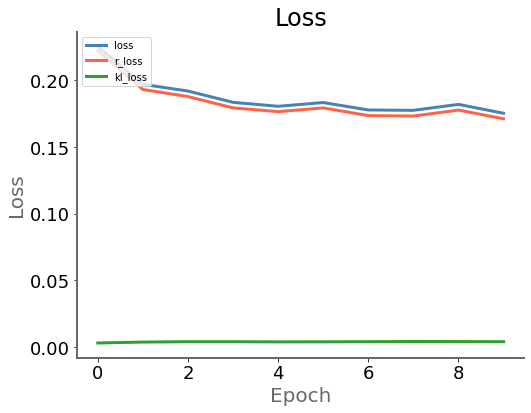

In [10]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

<br>**Original images :**

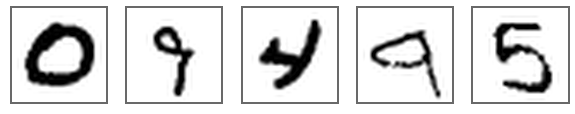

<br>**Encoded/decoded images**

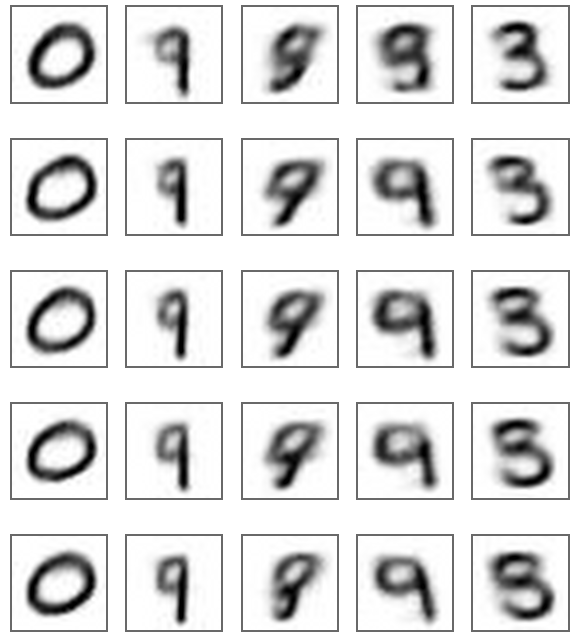

<br>**Original images :**

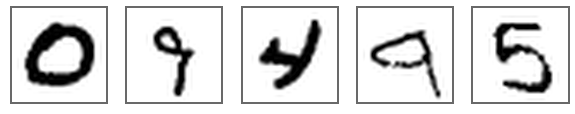

In [11]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-original')

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_data[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder) during training

<br>**Generated images from latent space**

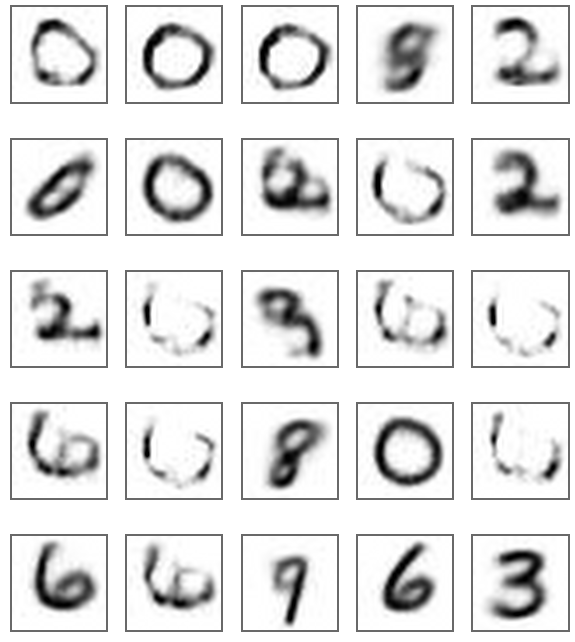

In [12]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='04-encoded')

## Step 7 - Model evaluation

### 7.1 - Reload best model

In [13]:
vae=VAE()
vae.reload(f'{run_dir}/models/best_model')

Fidle VAE is ready :-)  loss_weights=[1, 1]
Reloaded.


### 7.2 - Image reconstruction

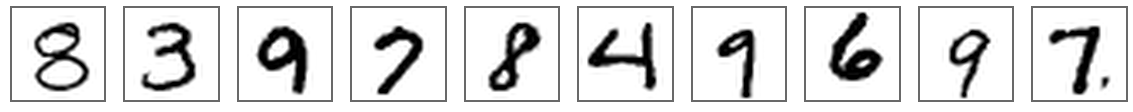

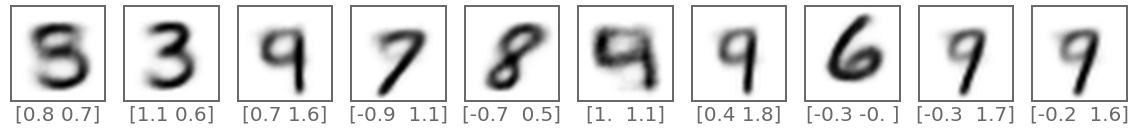

In [14]:
# ---- Select few images

x_show = pwk.pick_dataset(x_data, n=10)

# ---- Get latent points and reconstructed images

z_mean, z_var, z  = vae.encoder.predict(x_show)
x_reconst         = vae.decoder.predict(z)

# ---- Show it

labels=[ str(np.round(z[i],1)) for i in range(10) ]
pwk.plot_images(x_show,    None, indices='all', columns=10, x_size=2,y_size=2, save_as='05-original')
pwk.plot_images(x_reconst, labels  , indices='all', columns=10, x_size=2,y_size=2, save_as='06-reconstruct')


### 7.3 - Visualization of the latent space

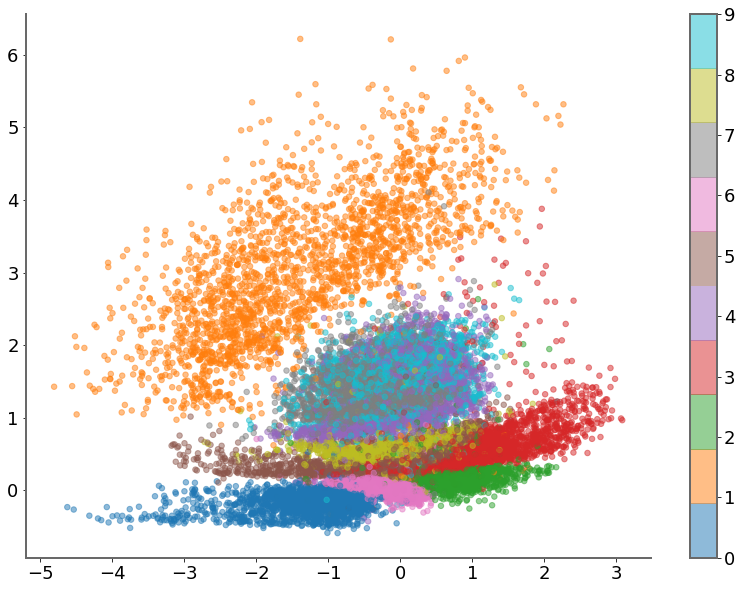

In [15]:
n_show = 20000

# ---- Select images

x_show, y_show = pwk.pick_dataset(x_data,y_data, n=n_show)

# ---- Get latent points

z_mean, z_var, z = vae.encoder.predict(x_show)

# ---- Show them

fig = plt.figure(figsize=(14, 10))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=30)
plt.colorbar()
pwk.save_fig('07-Latent-space')
plt.show()

### 7.4 - Generative latent space

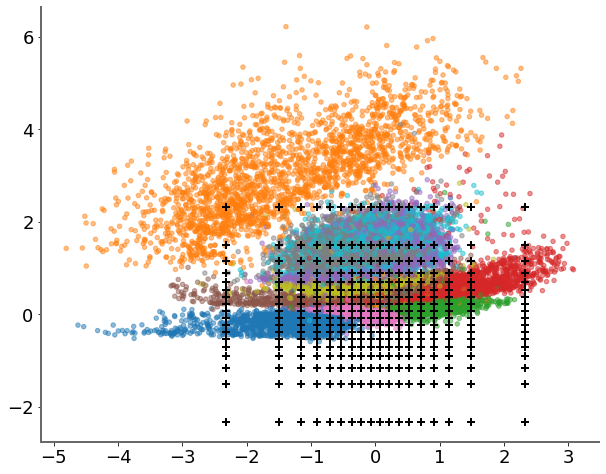

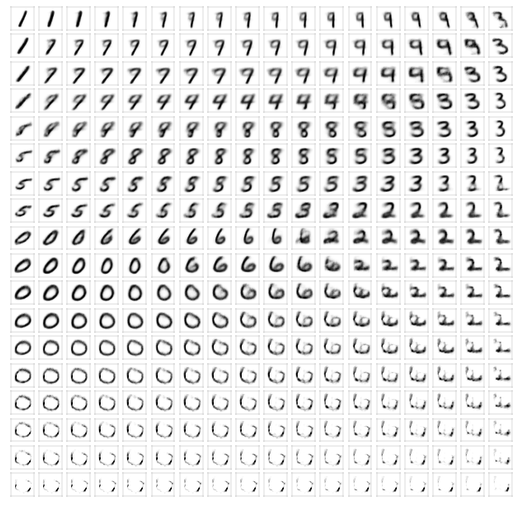

In [16]:
grid_size   = 18
grid_scale  = 1

# ---- Draw a ppf grid

grid=[]
for y in scipy.stats.norm.ppf(np.linspace(0.99, 0.01, grid_size),scale=grid_scale):
    for x in scipy.stats.norm.ppf(np.linspace(0.01, 0.99, grid_size),scale=grid_scale):
        grid.append( (x,y) )
grid=np.array(grid)

# ---- Draw latentspoints and grid

fig = plt.figure(figsize=(10, 8))
plt.scatter(z[:, 0] , z[:, 1], c=y_show, cmap= 'tab10', alpha=0.5, s=20)
plt.scatter(grid[:, 0] , grid[:, 1], c = 'black', s=60, linewidth=2, marker='+', alpha=1)
pwk.save_fig('08-Latent-grid')
plt.show()

# ---- Plot grid corresponding images

x_reconst = vae.decoder.predict([grid])
pwk.plot_images(x_reconst, indices='all', columns=grid_size, x_size=0.5,y_size=0.5, y_padding=0,spines_alpha=0.1, save_as='09-Latent-morphing')



In [17]:
pwk.end()

End time is : Monday 22 March 2021, 14:46:53
Duration is : 00:01:50 216ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>